In [ ]:
# Licensed under the Apache License, Version 2.0
import requests
import pandas as pd
import xarray as xr
import tempfile
import matplotlib.pyplot as plt
!pip install netCDF4
!pip install cartopy
import cartopy

In [ ]:
t0 = "2024-04-11T03:00:00"
t1 = "2024-04-11T06:00:00"
params = {
    "bbox": [
        -120,
        20,
        30,
        65,
    ],
    "aircraft_type": "A320",
}
times = pd.date_range(t0, t1, freq="1h")

In [ ]:
GOOGLE_URL = "https://contrails.googleapis.com/v1"
GOOGLE_API_KEY = "your_api_key"  #@param


In [ ]:
def get_ds(url, headers):
  ds_list = []

  for t in times:
    params["time"] = str(t)
    r = requests.get(url, params=params, headers=headers)
    print(f"HTTP Response Code: {r.status_code} {r.reason}")

    # Save request to disk, open with xarray, append grid to ds_list
    with tempfile.NamedTemporaryFile() as tmp, open(tmp.name, "wb") as file_obj:
        file_obj.write(r.content)
        ds = xr.load_dataset(tmp.name, engine="netcdf4", decode_timedelta=False)
    ds_list.append(ds)

  # Concatenate all grids into a single xr.Dataset
  return xr.concat(ds_list, dim="time")

In [ ]:
goog_ds = get_ds(f"{GOOGLE_URL}/grid/ef", {"x-goog-api-key": GOOGLE_API_KEY})

HTTP Response Code: 200 OK
HTTP Response Code: 200 OK
HTTP Response Code: 200 OK
HTTP Response Code: 200 OK


In [ ]:
goog_ds

<xarray.Dataset>
Dimensions:                            (longitude: 601, latitude: 181,
                                        flight_level: 18, time: 4)
Coordinates:
  * longitude                          (longitude) float64 -120.0 ... 30.0
  * latitude                           (latitude) float64 20.0 20.25 ... 65.0
  * flight_level                       (flight_level) int32 270 280 ... 430 440
  * time                               (time) int32 1712804400 ... 1712815200
Data variables:
    expected_effective_energy_forcing  (longitude, latitude, flight_level, time) float64 ...
Attributes:
    reftime:  [('us_forecast', 1712800800000000000), ('europe_forecast', 1712...

In [ ]:
def make_plot(ds):

  plt.figure(figsize=(25, 6))
  ax = plt.axes(projection=cartopy.crs.PlateCarree())
  # ax.set_extent(adjust_extent_to_pixel_center(visualization.EXTENT_LIMITS),
  #               crs=cartopy.crs.PlateCarree())
  im = ax.imshow(ds.isel(flight_level=6, time=0).values.T, origin='lower', transform=cartopy.crs.PlateCarree(), extent=(ds.longitude.min().item(), ds.longitude.max().item(), ds.latitude.min().item(), ds.latitude.max().item()))
  ax.coastlines()
  plt.colorbar(im)

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


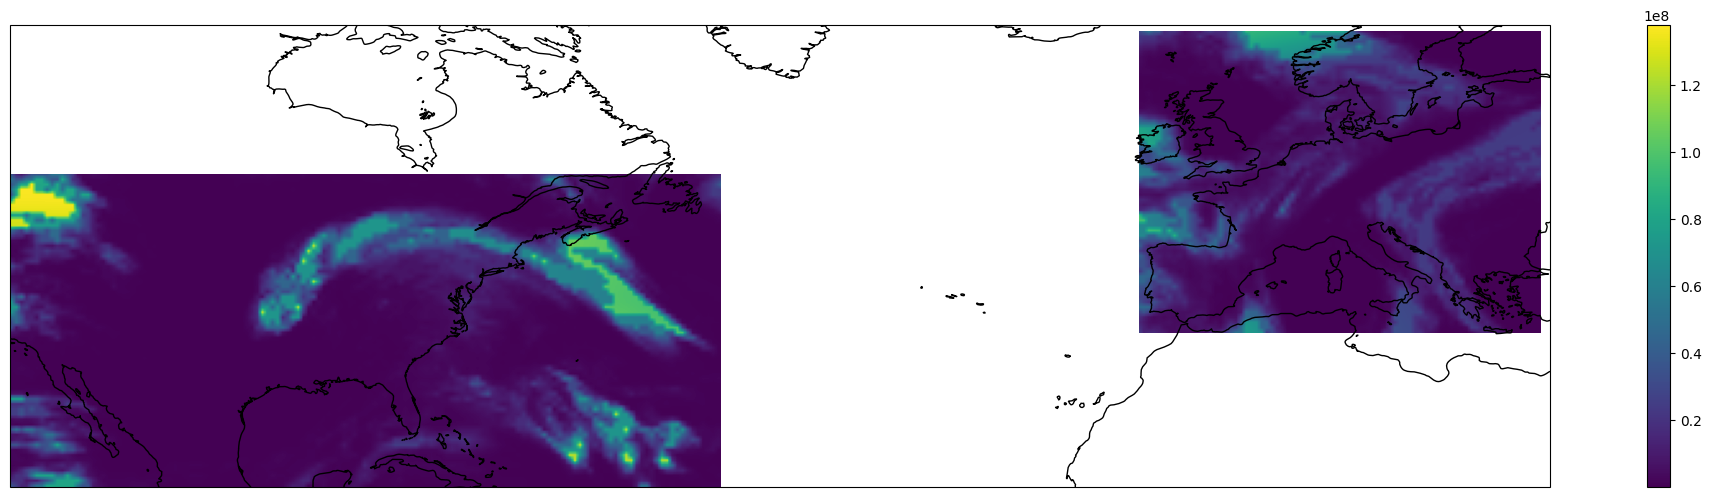

In [ ]:
make_plot(goog_ds['expected_effective_energy_forcing'])